# Text Rank

TextRank is a graph based algorithm that is used for keyword extraction as well as for summarization. The following lines are illustrating how to extract keywords based on the TextRank algorithm. 

https://www.google.de/search?q=TextRank&rlz=1C1CHBF_deDE784DE784&oq=TextRank&aqs=chrome..69i57j69i60j0j69i60l2j0.1196j0j7&sourceid=chrome&ie=UTF-8

## Data
Please insert you text for the key

In [1]:
text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

## Preprocessing
Before we start to peform the TextRank algorithm we normallz need to peform some preprocessing with the text. First of all we will tokenize the text and remove stop words afterwards lemmataization will be peformed.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

import numpy as np
import pandas as pd

### Lemmatizing text and create post tags

In [3]:

lemmatizer = WordNetLemmatizer()

tokenized_text = [x.lower() for x in nltk.word_tokenize(text)]
pos_tags = [x[1] for x in nltk.pos_tag(tokenized_text)]
#words = [x.lower() for x in tokenized_text]
lemmatized = [lemmatizer.lemmatize(x).lower() for x in tokenized_text] 

corpus = pd.DataFrame({
    "words": tokenized_text,
    "lemmatized": lemmatized,
    "pos_tag": pos_tags
})

### Removing stop words from the corpus
It's better to remove them after the pos tagging, otherwise the pos tagger doesnt work well.

In [4]:
stopWords = set(stopwords.words('english'))
corpus = corpus[~corpus['words'].isin(stopWords)].reset_index(drop = True)

In [5]:
corpus.head()

,lemmatized,pos_tag,words
0,compatibility,NN,compatibility
1,system,NNS,systems
2,linear,JJ,linear
3,constraint,NNS,constraints
4,set,NN,set


## Just keeping adjectives and nouns
Michaela et. al (2011) mention that the algorithm produces the best results with only considering adjectives and nouns. So let's remove the other grammatical parts. __But feel free to add other grammatical tags!__

In [6]:
# nltk.help.upenn_tagset() # List of possivle pos-tags

In [7]:
list_pos_tags = ["NN", "NNS", "JJ", "JJR", "JJS"] # This is a list of post-tags we want to keep in out corpus. Feel free to change 

In [8]:
corpus = corpus[corpus['pos_tag'].isin(list_pos_tags)].reset_index(drop = True)

In [9]:
corpus.head()

,lemmatized,pos_tag,words
0,compatibility,NN,compatibility
1,system,NNS,systems
2,linear,JJ,linear
3,constraint,NNS,constraints
4,set,NN,set


## Building the graph

In [10]:
import networkx as nx
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
sns.set_style("whitegrid")

In [12]:
# Parameter
window_size = 2

In [13]:
graph = nx.DiGraph()

In [14]:
# Every word in the corpus is an potential keyword
for index, word in enumerate(corpus["words"]):
    graph.add_node(word, pos_tag = corpus["pos_tag"][index],score=1)

In [15]:
# Finding co-occurences of window size n
length = len(corpus)
co_occurences = Counter()
_corpus = corpus["words"]
for index, word in enumerate(_corpus): 
    counter = 1
    if window_size + index <= length:
        while window_size > counter:
            pair = (word, _corpus[index+counter])
            #co_occurences.append(pair)
            co_occurences.update({pair: 1})
            counter += 1
    elif window_size + index > length: 
        # get the maxium number of sucessors
        new_window_size = window_size- (length - window_size + index)
        while new_window_size > counter:
            # print(new_window_size)
            # print(counter)
            # print(len(_corpus))
            # print(index+counter)
            pair = (word, _corpus[index+counter])
            co_occurences.update({pair: 1})
            #co_occurences.append(pair)
            counter += 1

In [16]:
# create edges between nodes
for key in co_occurences.keys():
    node = key[0]
    successor = key[1]
    weight = co_occurences[key]
    graph.add_edge(node, successor, weight = weight)

### Co-Occurences

In [17]:
adjacency = nx.to_pandas_adjacency(graph)

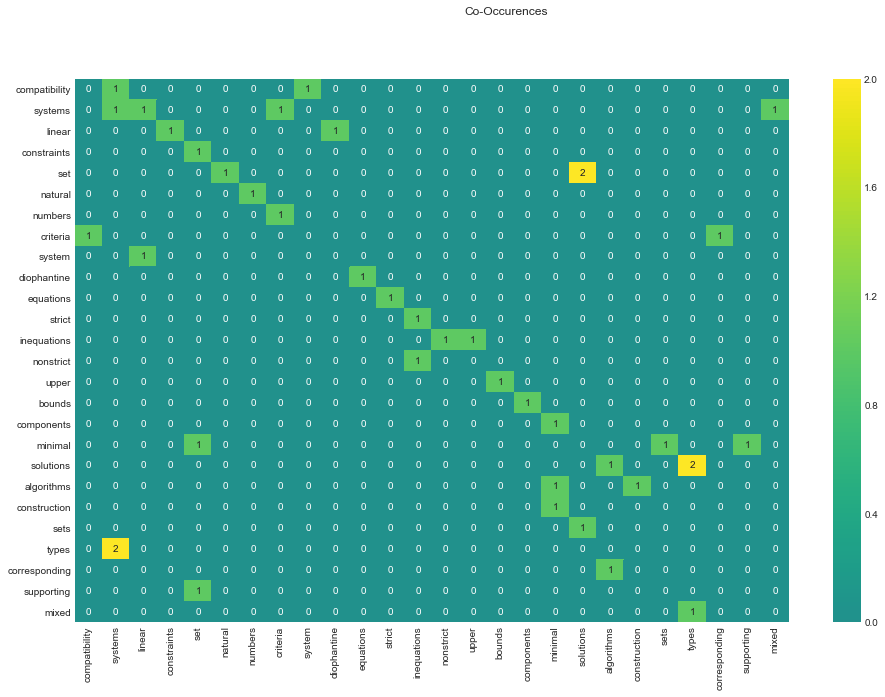

In [18]:
figure, ax = plt.subplots(1)
figure.suptitle("Co-Occurences")
figure.set_size_inches(16, 10)
ax = sns.heatmap(data = adjacency, cmap = "viridis", center = 0, ax = ax, annot = True,  mask = False)

### Graph

In [19]:
pos = nx.spring_layout(graph, k=1)  # Key is the factor which defines the space between nodes

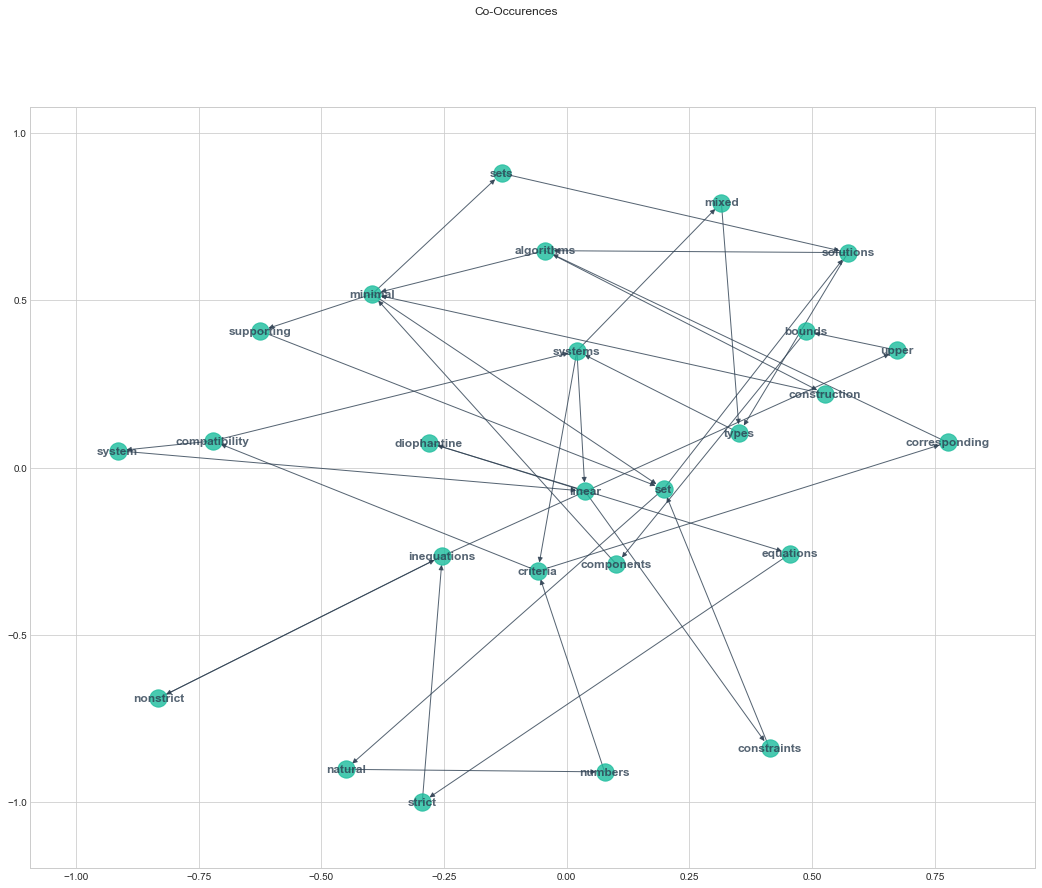

In [20]:
figure, ax = plt.subplots(1)
figure.suptitle("Co-Occurences")
figure.set_size_inches(18, 14)
nx.draw_networkx(graph, 
                 pos = pos,
                 ax = ax,
                 node_color = "#1abc9c",
                 edge_color = "#2c3e50",
                 cmap = "viridis",
                 edge_cmap = "plasma",
                 font_color = "#2c3e50",
                 font_weight = "bold", 
                 alpha = 0.8)

## Calculate Score of nodes

$$WS(V_i) = (1-d) + d \sum_{V_j \in In(V_i)} 
\frac{w_{ji}}
{\sum_{V_k \in Out(V_j)}W_{jk}}$$

In [21]:
def calculate_score(node, dumping_factor=0.85):
    if dumping_factor <= 0 or dumping_factor > 1:
        raise ValueError("Dumping Factor needs to be between 1 and 0")
    d = dumping_factor

    result = 0
    for incomming_node in graph.predecessors(node):
        vi = node
        vj = incomming_node
        vj_score = graph.node[vj]["score"]
        w_ji = graph[vj][vi]["weight"]
        sum_vj_succ = 0
        for succesor in graph.successors(vj):
            vk = succesor
            weight = graph[vj][vk]["weight"]
            sum_vj_succ += weight

        result += w_ji / sum_vj_succ * vj_score
    weighted_score = (1 - d) + d * result
    return weighted_score

### Find Keywords

In [22]:
iterations = 30

In [23]:
keywords = []
for i in range(iterations):
        for node in graph.nodes:
            ws = calculate_score(node=node)
            nx.set_node_attributes(graph, ws, name="score")
            if i == iterations - 1:
                keywords.append([str(node), (float(graph.nodes[node]["score"]))])
keywords = pd.DataFrame(keywords, columns = ["keyword", "score"]).sort_values(by = ["score"], ascending = False)

#### Which Keywords should be kept?
Is the number of top t keywords. Michaela et. all are suggesting a flexible approach where t is a third of the input text size. 

In [24]:
import math
t = math.floor(len(tokenized_text)/3)

In [25]:
keywords = keywords.iloc[:t].reset_index(drop = True)

In [26]:
keywords.head()

,keyword,score
0,algorithms,2.498173
1,solutions,2.071917
2,minimal,1.356647
3,construction,1.211723
4,inequations,1.041365


### Finding Keyphrases
To finde the keyphrases Michaela et. al (2011) are describing the approach as follows: 
<br>
<br>
*"During post-processing, all lexical units selected
as potential keywords by the TextRank algorithm are
marked in the text, and sequences of adjacent keywords
are collapsed into a multi-word keyword. For
instance, in the text Matlab code for plotting ambiguity
functions, if both Matlab and code are selected
as potential keywords by TextRank, since they are
adjacent, they are collapsed into one single keyword
Matlab code"*

In [27]:
maximum_length = 2


In [28]:
ngrams_text = nltk.ngrams(corpus["words"],maximum_length)

##### Marking the words
The basic idea of the following approach is, that we create a list of corpus["words"].length and we are using binary encoding if there is an occurence of our keywords at index n. 

In [29]:
zeros = np.zeros(shape = (len(tokenized_text)))

In [30]:
for index, word in enumerate(tokenized_text): 
    for keyword in keywords.iterrows():
        if word == keyword[1]["keyword"]:
            zeros[index] = 1

In [31]:
zeros

array([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 1., 1., 0.])

#### Counting the words which appear n time (*maximum_length*) after each other

In [32]:
counter = 0
candidate_keyphrases = []
for i, element in enumerate(zeros):
    if element == 1: 
        try:
            if zeros[i+1] == 1:
                try:
                    if zeros[i+2] == 1:
                        candidate_keyphrases.append((tokenized_text[i], tokenized_text[i+1], tokenized_text[i+2]))
                    else: 
                        candidate_keyphrases.append((tokenized_text[i], tokenized_text[i+1]))
                except Exception:
                    candidate_keyphrases.append((tokenized_text[i], tokenized_text[i+1]))
        except Exception: 
            pass

In [33]:
candidate_keyphrases

[('linear', 'constraints'),
 ('natural', 'numbers'),
 ('linear', 'diophantine', 'equations'),
 ('diophantine', 'equations'),
 ('strict', 'inequations'),
 ('nonstrict', 'inequations'),
 ('upper', 'bounds'),
 ('minimal', 'set'),
 ('corresponding', 'algorithms'),
 ('minimal', 'supporting', 'set'),
 ('supporting', 'set'),
 ('types', 'systems'),
 ('mixed', 'types')]

#### Calculating the score of keyphrases
Actually I have no idea how this is done. If I'm not mistaken there is also not one word about it in the paper of Michaela et al (2011). Im just taking the average of the words in the keyphrases and add them to our keyword df. 

In [34]:
keyphrases_lst = []
for keyphrase in candidate_keyphrases:
    scores = []
    for keyword in keyphrase:
        score = keywords.loc[keywords['keyword'] == keyword]["score"]
        scores.append(score.values[0])
    keyphrases_lst.append({"keyword": keyphrase, "score": np.mean(scores)})
    #keywords = keywords.append({"keyword": keyphrase, "score": np.mean(scores)}, ignore_index = True)
keyphrases = pd.DataFrame(keyphrases_lst)   

In [39]:
keyphrases = keyphrases.sort_values(by = ["score"], ascending = False)

In [40]:
keyphrases = keyphrases.iloc[:t].reset_index(drop = True)

In [41]:
keyphrases

,keyword,score
0,"(corresponding, algorithms)",1.504472
1,"(minimal, set)",1.192571
2,"(minimal, supporting, set)",0.893287
3,"(nonstrict, inequations)",0.816972
4,"(strict, inequations)",0.782848
5,"(types, systems)",0.678209
6,"(supporting, set)",0.661607
7,"(linear, constraints)",0.566103
8,"(mixed, types)",0.530750
9,"(linear, diophantine, equations)",0.490431


In [36]:
keywords.head()

,keyword,score
0,algorithms,2.498173
1,solutions,2.071917
2,minimal,1.356647
3,construction,1.211723
4,inequations,1.041365
